### Визуализация решающих поверхностей в kNN.

Изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html).

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn.datasets import load_wine # Импорт функции load_wine

data = load_wine() # load_wine возращает словареподобная структуру с ключами,
                   # позволяющими получить доступ к данным и их описанию

X = pd.DataFrame(data['data'], columns = data['feature_names'])
# Столбцы DataFrame должны быть названы согласно названиям признаков,
# которые можно получить из ключа feature_names объекта data

y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


 Есть ли в наборе данных пропущенные значения? Если да, то удалим их. Есть ли в наборе данных категориальные переменные? Если да, то закодируем их при помощи [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [ ]:
print(X.isnull().any().any())

# Предположим, что в наборе данных есть категориальные переменные.
# Будем считать, что признак категориален,
# если он имеет менее 10 уникальных значений в соответствующем столбце.
categorical_features = [col for col in X.columns if X[col].nunique() < 10]

print(f"Категориальные переменные: {categorical_features}")

False
Категориальные переменные: []


Пропущенных значений нет.

Категориальных переменных тоже. Впрочем, это можно увидеть и посмотрев на таблицу, выведенную в предыдущем пункте.

Используя функцию `train_test_split()`, разделим выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудем зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используем аргумент `stratify` при разбиении.

In [ ]:
from sklearn.model_selection import train_test_split
# train_test_split используется для разделения массивов
# на случайные подвыборки обучающего и тестового наборов

# Фиксируем случайное зерно для воспроизводимости результатов
np.random.seed(42)
# Число 42 часто используется как отсылка к "ответу на главный вопрос жизни,
# вселенной и всего такого" из книги Дугласа Адамса "Автостопом по галактике"

# Разделяем данные на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

Использовать аргумент stratify важно для того, чтобы обеспечить корректное распределение классов между тестовой и тренировочной выборкой. Чтобы не получилось так, что в тренировочную выборку попали таргеты преимущественно одних классов, а в тестовую -- других.

stratify=y указывает на то, что распределение меток в тренировочной и тестовой выборке должно быть таким же, как и в исходном наборе данных y.

На тренировочной выборке обучим шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставим равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратим внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения использем только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Масштабируем признаки при помощи модуля `StandardScaler`.

Выведем долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier # Для классификации методом kNN
from sklearn.preprocessing import StandardScaler # Для масштабирования признаков
from sklearn.metrics import accuracy_score # Для вычисления точности классификации

In [ ]:
# Создадим новые DataFrame, в которых сохраним только необходимые столбцы.
# Для этого нужно в исходный DataFrame передать список с названиями нужных столбцов.
# Отсюда возникает потребность в использовании двойных квадратных скобок.
cur_X_train = X_train[['alcohol', 'magnesium']]
cur_X_test = X_test[['alcohol', 'magnesium']]

# Масштабируем признаки. После применения StandardScaler все признаки
# будут иметь среднее значение 0 и стандартное отклонение 1.
scaler = StandardScaler() # Создаем объект scaler класса StandardScaler

cur_X_train = scaler.fit_transform(cur_X_train)
# fit_transform сначала находит среднее значение и стандартное отклонение
# каждого признака, а затем стандартизирует каждое значение соответствующего признака,
# вычитая среднее значение и деля на стандартное отклонение

cur_X_test = scaler.transform(cur_X_test)
# Метод transform стандартизирует значения cur_X_test, используя параметры,
# полученные при стандартизации cur_X_train. Это гарантирует то, что тестовые
# данные будут масштабированы так же, как и тренировочные.

neighbours_settings = np.array([1, 3, 5, 10, 15, 25]) # Число соседей по условию
classifires = []

print('NN\tTrain\tTest')
for quantity in neighbours_settings:
  knn = KNeighborsClassifier(n_neighbors=quantity)
  # По умолчанию используется евклидово расстояние

  # Проводим обучение
  knn.fit(cur_X_train, y_train)
  classifires.append(knn)

  y_train_pred = knn.predict(cur_X_train)
  train_accuracy = accuracy_score(y_train, y_train_pred)

  y_test_pred = knn.predict(cur_X_test)
  test_accuracy = accuracy_score(y_test, y_test_pred)

  print(quantity, f'{train_accuracy:.2f}', f'{test_accuracy:.2f}', sep='\t')
  # Запись вида f'{train_accuracy:.2f}' позволяет вывести число
  # с двумя знаками в дробной части

NN	Train	Test
1	1.00	0.56
3	0.80	0.63
5	0.78	0.63
10	0.75	0.65
15	0.72	0.63
25	0.69	0.69


In [ ]:
# Можно найти долю правильных ответов без использования функции accuracy_score
test_accuracy = (y_train == y_train_pred)
np.mean(test_accuracy)

0.6935483870967742

Установим библиотеку `mlxtend` командой ниже.

In [ ]:
!pip install mlxtend

In [ ]:
import mlxtend

Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучим [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и построим несколько графиков решающих поверхностей на сетке (decision regions grid) для обученных выше классификаторов.

In [ ]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 3) # Настройка сетки графиков, 2 строки и 3 столбца

pos = 0
for clf, label in zip(classifires, neighbours_settings):
    ax = plt.subplot(gs[pos // 3, pos % 3])
    fig = plot_decision_regions(X=cur_X_train, y=y_train, clf=clf, legend=2, ax=ax)
    plt.title(f'n_neighbours = {label}')
    pos += 1

plt.show()

Пронализиурем результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора?

Сначала посмотрим вывод в задании 1.3. С увеличением количества соседей, доля правильных ответов на тренировочной выборке уменьшается, что вероятно указывает на уменьшение переобучения.

Теперь проанализируем решающие поверхности.
*   При k = 1 разделение поверхности очень резкое, что говорит о переобучении. Модель учитывает все шумы и будет плохо работать на тестовой выборке, что подтверждается выводом доли точных ответов на тестовой выборке при этом гиперпараметре.
*   При k = 3 и k = 5 углы начинают сглаживаться. Уменьшается зеленый "остров" в нижней части графика. Переобучение становится менее выраженным, что подверждается величиной доли точных ответов на тестовой выборке (0.63).
*   При k = 10 решающие границы достаточно сглажены. Эта геометрия хорошо отражает принцип принятия решений для текущего набора. Показатели на train и test (0.75, 0.65 соответственно) хорошие.
*   При k = 15 и k = 25 решающие границы весьма сглажены, но модель может способность адаптироваться к более тонким структурам данных. При k=25 достигается такая же точность на тестовой выборке, как и на тренировочной, что может быть признаком утраты моделью возможности точно находить закономерности в данных.


**Вывод**:
На основе представленных данных и визуализаций можно предположить, что оптимальное число соседей в данном случае лежит где-то между 5 и 15. При k = 10 достигается хороший баланс между точностью на тренировочных и тестовых данных, и решающие границы кажутся разумно сглаженными без потери способности к адекватному разделению классов.
Переобучение явно наблюдается при k=1, где модель слишком подстраивается под данные, в то время как начиная с k=15 может наблюдаться недостаточное обучение, где модель начинает терять детализацию границ.







### KNN своими руками

Попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

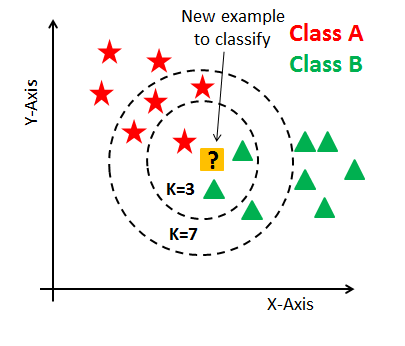

In [ ]:
import numpy as np
from collections import Counter

class KNN:
    def __init__(self, k:int):
      self.k = k

    def fit(self, X, y):
      self.X = X
      self.y = y

    def predict(self, X):
      predicts = []
      for x in X:
        distances = [self.count_distance(x, train_x) for train_x in self.X]
        indexes = np.argsort(distances)[:self.k]
        labels = self.y[indexes]

        counts = np.bincount(labels)
        predicts.append(np.argmax(counts))
      return np.array(predicts)

    def count_distance(self, x, y):
      return np.sqrt(np.square(x - y).sum())


In [1]:
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [ ]:
test_knn(KNN)

### Линейная регрессия.

Рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [ ]:
!wget https://github.com/d-da-das-dash-dasha/hw04_knn_linreg/raw/main/archive.zip
!unzip archive.zip


--2024-03-21 19:24:37--  https://github.com/d-da-das-dash-dasha/hw04_knn_linreg/raw/main/archive.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/d-da-das-dash-dasha/hw04_knn_linreg/main/archive.zip [following]
--2024-03-21 19:24:38--  https://raw.githubusercontent.com/d-da-das-dash-dasha/hw04_knn_linreg/main/archive.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 750893 (733K) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>] 733.29K  --.-KB/s    in 0.04s   

2024-03-21 19:24:38 (20.3 MB/s) - ‘archive.zip’ saved [750893/750893]

Archive:  archive.

In [ ]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

Есть ли в наборе данных пропущенные значения? Если да, удалим их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалим их.

In [ ]:
print(data.isnull().any().any())
data.drop('Unnamed: 0', axis=1, inplace=True)

False


Пропущенных значений нет, бессмысленный столбец -- "Unnamed: 0", был удален.

Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведем матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

In [ ]:
# Выведем матрицу корреляций.
# В data содержатся как числовые, так и категориальные признаки,
# поэтому выделим вещественные признаки.
data.select_dtypes(include=[np.number]).corr()
# include=[np.number] указывает на то, что нужно включить только те столбцы,
# тип данных которых относится к числовым типам данных в numpy (np.number)

,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


Сильнее всего с таргетом коррелирует вес бриллианта в каратах, что весьма разумно, потому что чем больше бриллиант, тем выше стоимость изделия.
Так же хорошо коррелируют показатели x, y, z, так как они тоже связаны с размером алмаза (это можно увидеть и по высокой корреляции этих признаков с признаком carat).

Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируем категориальные переменные при помощи OneHot-кодирования.

In [ ]:
data_encoded = pd.get_dummies(data, columns=['cut', 'color', 'clarity'])

Разделим выборку на тренировочную и тестовую. Долю тестовой выборки укажем равной 0.3.

In [ ]:
data_encoded['price_bin'] = pd.qcut(data_encoded['price'], q=10, labels=False)
X = data_encoded.drop(['price', 'price_bin'], axis=1)
y = data_encoded[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=data_encoded['price_bin'], random_state=42)

Если попробовать использовать параметр stratify=y в чистом виде, то мы столкнемся с такой проблемой: ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2. Поэтому я разделила данные на 10 квантильных бинов* и указала это разделение в параметре stratify.

*Квантильные бины — это способ разделения непрерывного распределения данных на равные по числу наблюдений интервалы.

Квантиль — это статистика, разделяющая распределение вероятности или выборку на равные части. Например, медиана делит упорядоченный набор данных на две равные части и является квантилем 0.5 (50% данных находится ниже медианы, и 50% — выше).

Под "разделением данных на квантильные бины" имеется в виду процесс группировки данных таким образом, чтобы в каждую группу попало одинаковое количество наблюдений.

Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. Масштабируем вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [ ]:
scaler = StandardScaler()

# Выбираем только вещественные признаки для масштабирования
X_train_numerical = X_train.iloc[:, :6]
X_test_numerical = X_test.iloc[:, :6]

# Масштабируем только вещественные признаки
X_train_numerical_scaled = scaler.fit_transform(X_train_numerical)
X_test_numerical_scaled = scaler.transform(X_test_numerical)

# Заменяем масштабированные вещественные признаки обратно в исходный датасет
X_train.iloc[:, :6] = X_train_numerical_scaled
X_test.iloc[:, :6] = X_test_numerical_scaled

          carat     depth     table         x         y         z  cut_Fair  \
51296 -0.143487 -0.587665 -0.650715  0.096556  0.048041  0.000933         0   
38090 -0.922611 -0.657362 -0.650715 -0.973020 -0.989387 -1.027086         0   
16587  0.446121  0.039613 -0.204856  0.542213  0.614703  0.578314         0   
17488  1.014671 -0.308875 -0.204856  1.148306  1.085468  1.057117         0   
49142 -0.564635 -0.657362 -0.650715 -0.438232 -0.405289 -0.477870         0   
...         ...       ...       ...       ...       ...       ...       ...   
14005  0.846211  0.109311  0.686862  1.005696  0.876239  0.944458         0   
14396 -1.048956 -0.169480 -0.204856 -1.267153 -1.216051 -1.238323         0   
27817 -0.964726  1.503261  0.241003 -1.160196 -1.163744 -1.013004         0   
19502  1.625336  3.872977  3.807875  1.888096  0.013169  0.465654         1   
3776  -0.185602  0.039613 -1.096574 -0.019315  0.030605  0.015016         0   

       cut_Good  cut_Ideal  cut_Premium  ...  color

Оценим линейную регрессию на тренировочной выборке. Выведем среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Создадим экземпляр модели линейной регрессии
lin_reg = LinearRegression()

# Обученим модель на тренировочной выборке
lin_reg.fit(X_train, y_train)

# Предскажем значения на тренировочной и тестовой выборках
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

# Вычислим среднеквадратичную ошибку для тренировочной и тестовой выборок
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f'MSE on train: {mse_train}, MSE on test: {mse_test}')

MSE on train: 1262179.9712925912, MSE on test: 1311217.0590965133


Изучим [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведем полученные оценки коэффициентов. Назовем вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [ ]:
for feature, coefficient in zip(X.columns, lin_reg.coef_[0]):
  print(f'{feature}: {coefficient}')

carat: 5337.249296327145
depth: -89.26941988837723
table: -63.83278012387622
x: -1135.512317840276
y: 17.700648297015526
z: -35.78033596365267
cut_Fair: -597.6794063851852
cut_Good: 13.540857033187729
cut_Ideal: 245.53088953429088
cut_Premium: 183.85925742732528
cut_Very Good: 154.74840239038127
color_D: 819.8353432543694
color_E: 624.7698491898298
color_F: 538.2742365847287
color_G: 345.49849207826446
color_H: -157.15225780391384
color_I: -650.2496441671835
color_J: -1520.976019136088
clarity_I1: -3775.216752626394
clarity_IF: 1496.701919718055
clarity_SI1: -133.2455223950692
clarity_SI2: -1115.9108388690465
clarity_VS1: 750.7933547350623
clarity_VS2: 452.51342454037393
clarity_VVS1: 1188.0596782739583
clarity_VVS2: 1136.3047366230576


Cреди вещественных переменных (carat, depth, table, x, y, z) особенно выделяется переменная carat: коэффициент 5337.249296327166.

Такой большой коэффициент подтверждает предположение о том, что вес имеет гораздо большее влияние на цену бриллианта по сравнению с другими вещественными параметрами.


Визуально сравним оценки коэффициентов по модулю и выберем те, разница между которыми в 10 и более раз. Среди вещественных переменных наиболее значительный коэффициент наблюдается у переменной x (длина в мм), коэффициент для которой составляет примерно 4.29091192e+00. Этот коэффициент значительно выше по модулю, чем коэффициенты других вещественных переменных.

Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучим Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используем модули `Lasso` и `Ridge` из `sklearn`.

In [ ]:
from sklearn.linear_model import Lasso, Ridge

alpha = 10

lasso_reg = Lasso(alpha=alpha)
lasso_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=alpha)
ridge_reg.fit(X_train, y_train)

for feature, lin_coef, lasso_coef, reg_coef in zip(X.columns, lin_reg.coef_[0], lasso_reg.coef_, ridge_reg.coef_[0]):
  print(f'{feature}: {lin_coef, lasso_coef, reg_coef}')
# lin_reg.coef_ возвращает коэффициенты в виде матрицы, поэтому берем нулевой индекс
# lasso_reg.coef_ возвращает коэффициенты непосредственно как одномерный массив
# ridge_reg.coef_ возвращает коэффициенты в виде матрицы, поэтому берем нулевой индекс

carat: (5337.249296327145, 4857.947137474239, 5297.711017198622)
depth: (-89.26941988837723, -99.73141945125882, -87.82656866708783)
table: (-63.83278012387622, -83.73262885994113, -64.25700411727935)
x: (-1135.512317840276, -715.2234790791881, -1092.6256769963088)
y: (17.700648297015526, -0.0, 14.376181895050703)
z: (-35.78033596365267, -33.55370808016345, -39.53527618951302)
cut_Fair: (-597.6794063851852, -457.4958140039168, -599.9180256566344)
cut_Good: (13.540857033187729, -26.602239573794392, 13.44827465335816)
cut_Ideal: (245.53088953429088, 74.26296580610942, 246.45240089332663)
cut_Premium: (183.85925742732528, 0.0, 183.80479159926472)
cut_Very Good: (154.74840239038127, 0.0, 156.21255851102413)
color_D: (819.8353432543694, 326.1306264696705, 814.9880434051921)
color_E: (624.7698491898298, 171.48145676989648, 621.1068823349017)
color_F: (538.2742365847287, 94.74877029615409, 534.6023320748762)
color_G: (345.49849207826446, 0.0, 343.86900929896393)
color_H: (-157.15225780391384,

L1- и L2-регуляризации упрощают модель, снижая влияние менее важных признаков.

**L1-регуляризация** работает таким образом, что она может полностью исключать некоторые из менее важных признаков из модели, устанавливая их веса в ноль, что мы и получили для вещественно признака y. Остальные веса значительно уменьшились по сравнению с L2-регуляризацией (за исключением признака z, там разинца не такая большая).

**L2-регуляризация** вместо исключения признаков просто уменьшает их влияние на модель, делая веса признаков ближе к нулю, но не равными нулю. Это помогает снизить переобучение, сохраняя при этом все признаки в модели. При этом  в нашем примере коэффициенты вещественных признаков почти не изменились, что может говорить о сохранении их значимости согласно этой регуляризации.

Проблема мультиколлинеарности проявилось, потому что L1-регуляризация занулила значение y, а L2-регуляризация уменьшила вклад большинства переменных. Однако стоит заметить, что проблема не очень значительна.

Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучим Lasso- и Ridge-регрессии и построем график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.392e+07, tolerance: 6.001e+07
  model = cd_fast.enet_coordinate_descent(


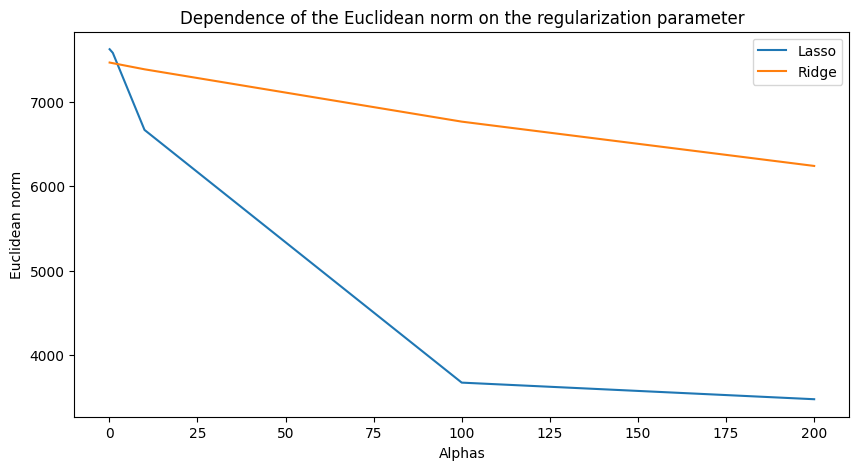

In [ ]:
norms_lasso = []
norms_ridge = []
alphas = [0.1, 1, 10, 100, 200]

for alpha in alphas:
  lasso_reg = Lasso(alpha=alpha)
  lasso_reg.fit(X_train, y_train)
  norms_lasso.append(np.linalg.norm(lasso_reg.coef_))

  ridge_reg = Ridge(alpha=alpha)
  ridge_reg.fit(X_train, y_train)
  norms_ridge.append(np.linalg.norm(ridge_reg.coef_[0]))

plt.figure(figsize=(10, 5))
plt.plot(alphas, norms_lasso, label='Lasso')
plt.plot(alphas, norms_ridge, label='Ridge')

plt.title('Dependence of the Euclidean norm on the regularization parameter')
plt.xlabel('Alphas')
plt.ylabel('Euclidean norm')
plt.legend()

plt.show()

На графике **Lasso регрессии** видны "переломы", которые связаны с тем, что L1-регуляризация способствует обнулению коэффициентов. С увеличением α все больше коэффициентов становятся равными нулю, что приводит к ступенчатому уменьшению евклидовой нормы. Каждый "перелом" на графике соответствует значению α, при котором один или несколько коэффициентов обнуляются, вызывая резкое изменение в норме.

В случае **Ridge регрессии** таких "переломов" нет, поскольку L2-регуляризация уменьшает все коэффициенты пропорционально, но ни один из них не обнуляется полностью. График Ridge регрессии показывает более плавное и монотонное уменьшение евклидовой нормы по мере увеличения α.

Lasso регуляризация более агрессивная, при этом ее часто используют для отбора признаков именно потому, что она зануляет менее значимые признаки и помогает бороться с мультиколлинеарностью.

В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором мы подаём их в функцию: для определения порядка используем атрибут `.alphas_` Установим количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредним ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберем то значение, которое даёт наибольшее качество.

In [ ]:
from sklearn.linear_model import LassoCV

# Создаем экземпляр модели LassoCV
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42)

# Обучаем модель на тренировочной выборке
lasso_cv.fit(X_train, y_train)

# Получаем MSE для каждого значения альфа и усредняем по участкам кросс-валидации
mse_means = lasso_cv.mse_path_.mean(axis=1)

# Определяем оптимальное значение альфа
optimal_alpha = lasso_cv.alphas_[np.argmin(mse_means)]
# np.argmin возвращает индекс наименьшего значения в массиве mse_means
# lasso_cv.alphas_: Это атрибут экземпляра LassoCV, который содержит массив значений alpha.
# Этот массив синхронизирован с массивом mse_means

print(f'Оптимальное значение альфа: {optimal_alpha}')

# Выводим усредненные MSE для каждого значения альфа
for alpha, mse_mean in zip(lasso_cv.alphas_, mse_means):
    print(f'Альфа: {alpha}, усредненное MSE: {mse_mean}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167754644.41527557, tolerance: 48296580.15020016
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9353732977.490929, tolerance: 48296580.15020016
  model = cd_fast.enet_coordinate_descent_gram(


Оптимальное значение альфа: 1.0
Альфа: 200.0, усредненное MSE: 2411789.6903059357
Альфа: 100.0, усредненное MSE: 2210928.696705435
Альфа: 10.0, усредненное MSE: 1303913.4146679244
Альфа: 1.0, усредненное MSE: 1273644.4416454253
Альфа: 0.1, усредненное MSE: 1336527.4994230326


Наибольшее качество дает alpha = 1.0.

Обучим итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведем полученные коэффициенты и проанализируем, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведем возможное смысловое объяснение этого результата.

In [ ]:
lasso_reg = Lasso(alpha=1.0)
lasso_reg.fit(X_train, y_train)

for feature, coefficient in zip(X.columns, lasso_reg.coef_):
  print(f'{feature}: {coefficient}')

carat: 5289.701296296592
depth: -90.78924267633373
table: -65.77182999196698
x: -1079.8513202306676
y: 0.0
z: -33.88397281120643
cut_Fair: -725.7061235365229
cut_Good: -131.76654173086644
cut_Ideal: 87.05595863705913
cut_Premium: 21.787568392989893
cut_Very Good: 0.0
color_D: 459.91949125532466
color_E: 268.78507192458653
color_F: 183.2666050429027
color_G: 0.0
color_H: -496.24734914300524
color_I: -982.6646712178458
color_J: -1842.9107492004166
clarity_I1: -4242.891767108745
clarity_IF: 923.0685599080117
clarity_SI1: -670.2522187824857
clarity_SI2: -1646.5748050216766
clarity_VS1: 201.03944819672208
clarity_VS2: -83.71404177969596
clarity_VVS1: 631.1873678228407
clarity_VVS2: 584.5758536037066


Вещественные признаки:
*  Признак y (ширина в мм) оказался неинформативным и занулился.
*  Признак z (глубина в мм) оказался не особо информативным, поэтому его коэффициент маленький по модулю.
*  Признак carat оказался самым информативным, чего и следовало ожидать. Я об этом писала еще в самом начале исследования.
*   Признаки y и z неинформативны по причине того, что они вступают в мультиколлинеарность с признаком carat.
*   Обратим особое внимание на коэффициент при x. Отрицательный коэффициент может указывать на то, что с увеличением длины бриллианта его цена уменьшается, при условии что все остальные признаки остаются постоянными. Это может показаться нелогичным, так как обычно больший размер ассоциируется с более высокой ценой. Однако это как раз может быть признаком мультиколлинеарности, где x, y и z (размеры бриллианта) сильно коррелируют с carat (весом бриллианта), который имеет большой положительный коэффициент. Такая корреляция может вызвать неинтуитивные знаки коэффициентов.
*   x имеет большой отрицательный коэффициент, это может быть вызвано тем, что модель пытается "скомпенсировать" влияние коррелированного признака carat.

Категориальные признаки:
*   clarity_I1 сильно отрицательно коррелирует с таргетом, потому что это наихудший представленный показатель чистоты алмаза.
*   Также мы можем увидеть интересное распределение коэффициентов между категориальными признаками цвета, закодированными OHE: самый лучший цвет вносит большой положительный вклад в стоимость бриллианта, средний цвет не влияет на стоимоть, а худший цвет вносит большой отрицательный вклад в стоимость.
*   Неинформативные признаки: cut_Very Good и color_G.












Сделаем предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии.

In [ ]:
y_test_predicted_lin_reg = lin_reg.predict(X_test)
y_test_predicted_lasso_reg = lasso_reg.predict(X_test)

print(f'Linear regression MSE: {mean_squared_error(y_test_predicted_lin_reg, y_test)}')
print(f'Lasso regression MSE: {mean_squared_error(y_test_predicted_lasso_reg, y_test)}')

Linear regression MSE: 1311217.0590965133
Lasso regression MSE: 1312457.010649422


Среднеквадратичные ошибки оказались примерно равны. Возможно, это из-за того, что параметр alpha небольшой и L1-регуляризация не так выражена.
Можно использовать и другие метрики, чтобы посмотреть разницу в величине ошибок там.

Тем не менее, линейная регрессия показывает себя немного лучше. Возможно, из-за регуляризации модель стала менее чувствительна к некоторым важным тонкостям данных.